<a href="https://colab.research.google.com/github/Mayaamohamed/Material-Stream-Identification-System-assigment/blob/main/Ml_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import numpy as np
from PIL import Image, ImageOps
import hashlib
import random
import matplotlib.pyplot as plt
from collections import Counter, defaultdict 

In [2]:
import numpy as np
import cv2

def augment_image_cv(img, num_augments=1,
                     rotation_range=15, shift_range=5,
                     brightness_range=(0.8, 1.2), contrast_range=(0.8, 1.2),
                     h_flip_prob=0.5, v_flip_prob=0.2,
                     noise_std=0.02):
    """
    img: numpy array of shape (H,W,3) or (H,W), values [0,1]
    num_augments: number of augmented images to create
    returns: list of augmented images
    """
    augmented = []
    img = img.astype(np.float32)
    h, w = img.shape[:2]

    for _ in range(num_augments):
        aug = img.copy()

        # ----- Random rotation -----
        angle = np.random.uniform(-rotation_range, rotation_range)
        M_rot = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
        aug = cv2.warpAffine(aug, M_rot, (w, h), borderMode=cv2.BORDER_REFLECT)

        # ----- Random shift -----
        tx = np.random.uniform(-shift_range, shift_range)
        ty = np.random.uniform(-shift_range, shift_range)
        M_shift = np.float32([[1, 0, tx], [0, 1, ty]])
        aug = cv2.warpAffine(aug, M_shift, (w, h), borderMode=cv2.BORDER_REFLECT)

        # ----- Random flips -----
        if np.random.rand() < h_flip_prob:
            aug = cv2.flip(aug, 1)
        if np.random.rand() < v_flip_prob:
            aug = cv2.flip(aug, 0)

        # ----- Random brightness adjustment -----
        factor_b = np.random.uniform(brightness_range[0], brightness_range[1])
        aug = aug * factor_b

        # ----- Random contrast adjustment -----
        factor_c = np.random.uniform(contrast_range[0], contrast_range[1])
        mean = np.mean(aug)
        aug = np.clip((aug - mean) * factor_c + mean, 0, 1)

        # ----- Add Gaussian noise -----
        noise = np.random.normal(0, noise_std, aug.shape)
        aug = np.clip(aug + noise, 0, 1)

        # Ensure 3 channels for color images
        if img.ndim == 3 and img.shape[2] == 3:
            if aug.ndim == 2:
                aug = cv2.cvtColor(aug, cv2.COLOR_GRAY2BGR)

        augmented.append(aug)

    return augmented



In [3]:
def load_dataset(root_folder, img_size=(128, 128), min_size=32, target_count=500):
    """
    Load images from folders, apply preprocessing and data augmentation
    to balance classes up to target_count images per class.
    """
    X = []
    y = []
    seen_hashes = set()

    classes = [d for d in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, d))]
    print("Classes found:", classes)

    for class_name in classes:
        class_path = os.path.join(root_folder, class_name)
        images_in_class = []

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            # Skip 0kb images
            if os.path.getsize(img_path) == 0:
                continue

            # Repair EXIF transpose
            try:
                pil_img = Image.open(img_path)
                pil_img = ImageOps.exif_transpose(pil_img)
            except:
                continue

            img = np.array(pil_img)

            # Skip small images
            if img.shape[0] < min_size or img.shape[1] < min_size:
                continue

            # Skip duplicates using hash
            img_hash = hashlib.sha1(img.tobytes()).hexdigest()
            if img_hash in seen_hashes:
                continue
            seen_hashes.add(img_hash)

            # Resize
            img = cv2.resize(img, img_size)

            # Convert to grayscale
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Normalize
            img = img / 255.0

            images_in_class.append(img)

        current_count = len(images_in_class)
        print(f"Class '{class_name}': {current_count} original images loaded")

        if current_count == 0:
            print(f"  WARNING: No images found for class '{class_name}'")
            continue

        # Augmentation to reach target_count
        num_needed = max(0, target_count - current_count)
        augmented_images = []

        for img in images_in_class:
            num_aug_per_img = (num_needed // max(1, current_count)) + 1
            augmented_images.extend(augment_image_cv(img, num_aug_per_img))

        all_images = images_in_class + augmented_images[:num_needed]
        print(f"  {len(all_images) - current_count} images augmented for class '{class_name}'")
        print(f"  Total images for class '{class_name}' after augmentation: {len(all_images)}")

        for img in all_images:
            X.append(img.flatten())
            y.append(class_name)

    print("\nFinal counts per class after full augmentation:")
    print(Counter(y))

    return np.array(X), np.array(y)




In [ ]:
root_folder = "/content/datasetml"
X, y = load_dataset(root_folder)
print(np.unique(y))


Classes found: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Class 'cardboard': 247 original images loaded
  253 images augmented for class 'cardboard'
  Total images for class 'cardboard' after augmentation: 500
Class 'glass': 385 original images loaded
  115 images augmented for class 'glass'
  Total images for class 'glass' after augmentation: 500
Class 'metal': 314 original images loaded
  186 images augmented for class 'metal'
  Total images for class 'metal' after augmentation: 500
Class 'paper': 449 original images loaded
  51 images augmented for class 'paper'
  Total images for class 'paper' after augmentation: 500
Class 'plastic': 363 original images loaded
  137 images augmented for class 'plastic'
  Total images for class 'plastic' after augmentation: 500
Class 'trash': 106 original images loaded
  394 images augmented for class 'trash'
  Total images for class 'trash' after augmentation: 500

Final counts per class after full augmentation:
Counter({'cardboar

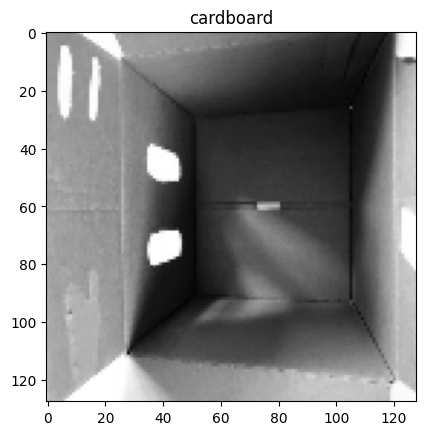

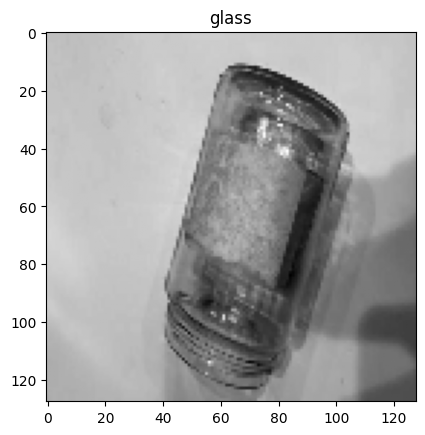

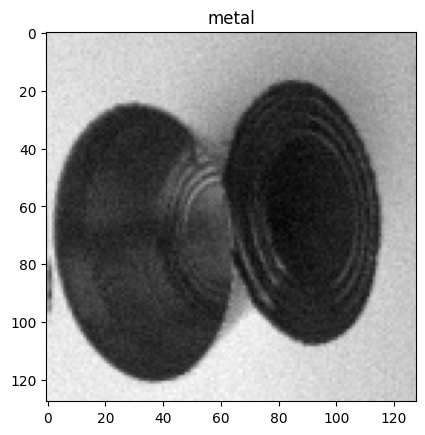

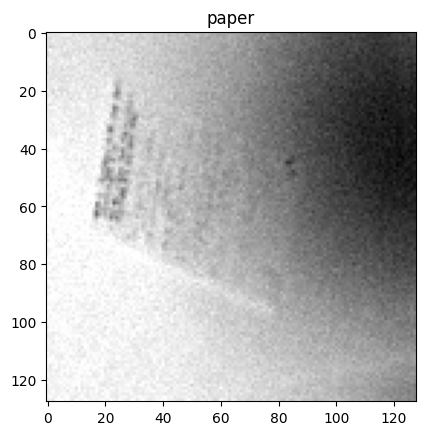

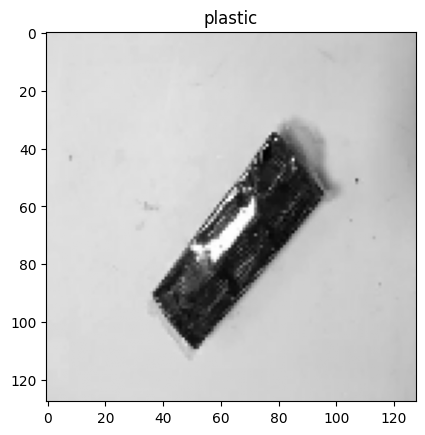

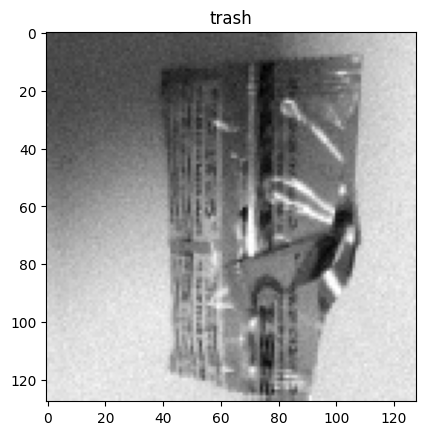

In [11]:
import random
import matplotlib.pyplot as plt
from collections import defaultdict
class_indices = defaultdict(list)
for idx, label in enumerate(y):
    class_indices[label].append(idx)
for class_name, indices in class_indices.items():
    idx = random.choice(indices)
    plt.imshow(X[idx].reshape(128,128), cmap='gray')
    plt.title(class_name)
    plt.show()


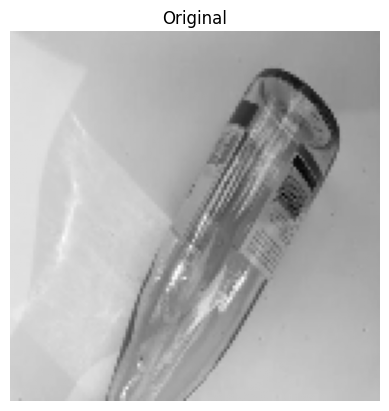

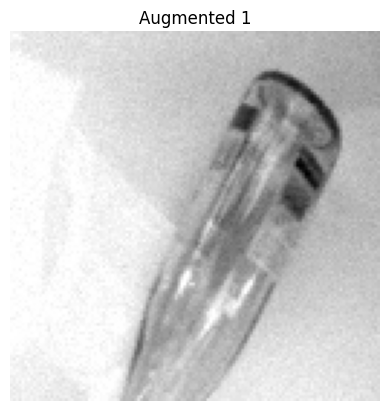

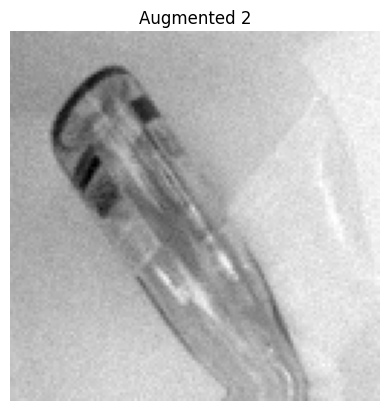

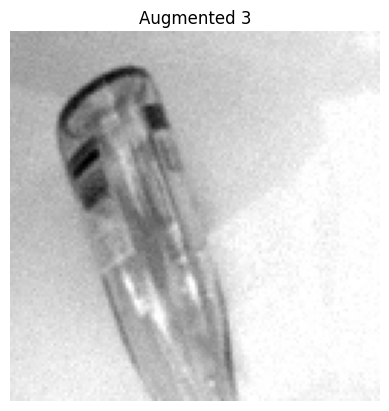

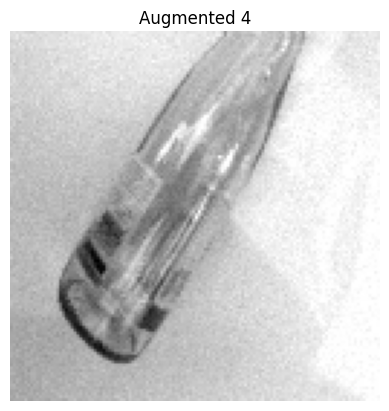

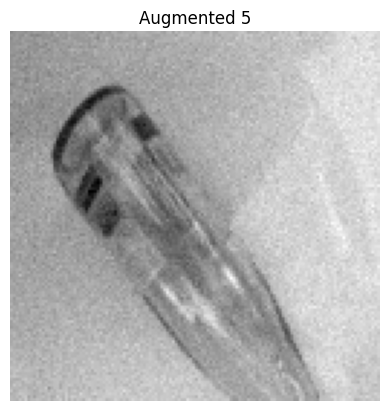

In [12]:
import matplotlib.pyplot as plt
import random

idx = random.randint(0, len(X)-1)
original_img = X[idx].reshape(128,128)

plt.imshow(original_img, cmap='gray')
plt.title("Original")
plt.axis('off')
plt.show()

augmented_imgs = augment_image_cv(original_img, num_augments=5)
for i, aug_img in enumerate(augmented_imgs):
    plt.imshow(aug_img, cmap='gray')
    plt.title(f"Augmented {i+1}")
    plt.axis('off')
    plt.show()
